# 얼굴 이미지에서 관상 생성하기

이 노트북은 얼굴 이미지를 분석하여 관상을 생성하는 방법을 보여줍니다. 다음과 같은 2단계 프로세스를 사용합니다:

1. **얼굴 분석**: Amazon Bedrock의 Nova 모델을 사용하여 얼굴 특징을 분석합니다.
2. **관상 생성**: 분석된 얼굴 특징을 기반으로 관상을 생성합니다.

## 필요한 라이브러리 설치

In [1]:
# 필요한 라이브러리 설치
!pip install boto3 pillow matplotlib

Defaulting to user installation because normal site-packages is not writeable


## 필요한 라이브러리 임포트

In [2]:
import boto3
import json
import os
import pprint
from PIL import Image
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError
import logging
import base64
from io import BytesIO
from IPython.display import display, HTML, Markdown

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## AWS 자격 증명 확인

In [3]:
# AWS 자격 증명이 올바르게 설정되어 있는지 확인
try:
    boto3.client('sts').get_caller_identity()
    print("✅ AWS 자격 증명이 올바르게 설정되어 있습니다.")
except Exception as e:
    print("❌ AWS 자격 증명 설정에 문제가 있습니다.")
    print(f"오류 메시지: {e}")
    print("AWS CLI를 사용하여 'aws configure' 명령으로 자격 증명을 설정하세요.")

INFO:botocore.credentials:Found credentials from IAM Role: vscode-on-ec2-CodeServerInstanceBootstrapRole-ZnimVDAk9q8X


✅ AWS 자격 증명이 올바르게 설정되어 있습니다.


## 이미지 로드 및 표시 함수

In [4]:
def load_and_display_image(image_path):
    """이미지를 로드하고 표시하는 함수"""
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('얼굴 이미지')
    plt.show()
    return img

## 이미지 경로 설정 및 이미지 표시

/home/participant/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50620 (\N{HANGUL SYLLABLE EOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/participant/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44404 (\N{HANGUL SYLLABLE GUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/participant/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/participant/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/participant/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from fo

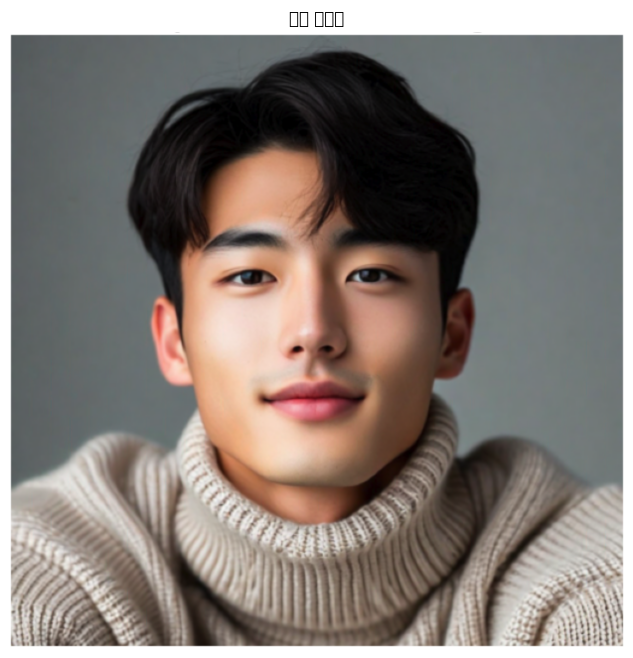

In [5]:
# 샘플 이미지 경로 설정
image_path = "sample/sample_face.png"

# 이미지 로드 및 표시
img = load_and_display_image(image_path)

## 1단계: 얼굴 분석 함수 구현 (Nova 모델 사용)

In [6]:
def analyze_face(image_path):
    """
    얼굴 이미지를 분석하여 특징을 추출하는 함수 (Nova 모델 사용)
    """
    # 모델 ID 설정 - Nova Lite 모델
    model_id = "us.amazon.nova-lite-v1:0"
    
    # 이미지를 base64로 인코딩
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    
    # Bedrock 클라이언트 생성
    bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')
    
    # 프롬프트 작성
    system_prompt = "당신은 얼굴에 대해서 분석하는 AI 입니다. 얼굴에 대한 분석과 핵심 키워드를 추출하는 것이 역할입니다. 모든 출력의 내용에 얼굴에 대한 부정적인 내용은 담지 않습니다."
    
    user_prompt = """
이 사진 속 인물의 얼굴에 대해서 아래 요소들을 상세히 설명해서 <description> 태그 안에 서술형으로 작성해주세요.

- 얼굴형 (둥근형, 계란형, 각진형 등)
- 눈의 특징 (크기, 모양, 쌍꺼풀 유무 등)
- 코의 특징 (길이, 모양, 콧대 높이 등)
- 입술의 특징 (두께, 모양, 특이점 등)
- 피부 특징 (피부톤, 특이점 등)
- 특별히 도드라지는 얼굴 특징이나 표정
- 헤어스타일 (길이, 컬러, 스타일 등)

그리고 핵심 키워드 10개를 추출해서 <keywords> 태그 안에 작성해주세요.
"""
    
    try:
        # 시스템 프롬프트 설정
        system_list = [
            {
                "text": system_prompt
            }
        ]
        
        # 사용자 메시지 설정 (이미지 포함)
        message_list = [
            {
                "role": "user",
                "content": [
                    {
                        "image": {
                            "format": "png",
                            "source": {
                                "bytes": encoded_string
                            }
                        }
                    },
                    {
                        "text": user_prompt
                    }
                ]
            }
        ]
        
        # 추론 파라미터 설정
        inf_params = {"maxTokens": 1000, "temperature": 0.3}
        
        # 요청 본문 구성
        native_request = {
            "schemaVersion": "messages-v1",
            "messages": message_list,
            "system": system_list,
            "inferenceConfig": inf_params
        }
        
        # API 요청
        response = bedrock_runtime.invoke_model(
            modelId=model_id, 
            body=json.dumps(native_request)
        )
        
        # 응답 처리
        model_response = json.loads(response["body"].read())
        result_text = model_response["output"]["message"]["content"][0]["text"]
        
        print("\n얼굴 분석 결과:")
        print(result_text)
        
        return result_text

    except ClientError as err:
        message = err.response['Error']['Message']
        logger.error("A client error occurred: %s", message)
        print(f"클라이언트 오류 발생: {message}")
        return None

## 얼굴 분석 실행

In [7]:
# 얼굴 분석 실행
face_analysis = analyze_face(image_path)


얼굴 분석 결과:
<description>
이 사진 속 인물의 얼굴은 계란형으로, 얼굴의 전체적인 길이보다 넓이가 더 뚜렷합니다. 눈은 중간 크기로, 모양은 타원형이며 쌍꺼풀이 없습니다. 코는 중간 길이로, 콧대는 높지 않고 자연스럽게 위치해 있습니다. 입술은 중간 두께로, 모양은 자연스럽게 웃고 있어 입술의 모양이 잘 드러나지 않습니다. 피부톤은 밝고 균일하며, 특이한 흠집이나 얼룩은 없습니다. 특별히 도드라지는 얼굴 특징이나 표정은 없으며, 전체적으로 자연스럽고 상큼한 인상을 줍니다. 헤어스타일은 짧은 길이로, 색상은 검은색이며 스타일은 자연스럽게 어깨까지 내려온 앞머리가 특징적입니다.
</description>
<keywords>
계란형, 타원형 눈, 중간 길이 코, 자연스러운 입술, 밝은 피부톤, 자연스러운 표정, 짧은 헤어스타일, 검은색 머리, 상큼한 인상, 자연스러운 앞머리
</keywords>


## 2단계: 관상 생성 함수 구현 (Nova 모델 사용)

In [8]:
def read_face(face_desc):
    """
    얼굴 분석 결과를 기반으로 관상을 생성하는 함수 (Nova 모델 사용)
    """
    # 모델 ID 설정 - Nova Lite 모델
    model_id = "us.amazon.nova-lite-v1:0"
    
    # Bedrock 클라이언트 생성
    bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')
    
    # 프롬프트 작성
    system_prompt = "당신은 관상학 전문가입니다. 제공된 얼굴 분석 정보를 바탕으로 관상을 생성해주세요. 관상은 긍정적인 내용으로만 작성하고, 부정적인 내용은 포함하지 마세요."
    
    user_prompt = f"""
다음 얼굴 분석 정보를 바탕으로 관상을 생성해주세요. 다음 항목에 대해 상세히 설명해주세요:

1. 얼굴형과 전체적인 인상에 따른 성격과 운세
2. 눈의 특징에 따른 지혜와 통찰력
3. 코와 입의 특징에 따른 재물운과 대인관계
4. 전체적인 얼굴 균형에 따른 미래 운세
5. 종합적인 관상 해석과 조언

얼굴 분석 정보:
{face_desc}
"""
    
    try:
        # 시스템 프롬프트 설정
        system_list = [
            {
                "text": system_prompt
            }
        ]
        
        # 사용자 메시지 설정
        message_list = [
            {
                "role": "user",
                "content": [
                    {
                        "text": user_prompt
                    }
                ]
            }
        ]
        
        # 추론 파라미터 설정
        inf_params = {"maxTokens": 2000, "temperature": 0.3}
        
        # 요청 본문 구성
        native_request = {
            "schemaVersion": "messages-v1",
            "messages": message_list,
            "system": system_list,
            "inferenceConfig": inf_params
        }
        
        # API 요청
        response = bedrock_runtime.invoke_model(
            modelId=model_id, 
            body=json.dumps(native_request)
        )
        
        # 응답 처리
        model_response = json.loads(response["body"].read())
        result_text = model_response["output"]["message"]["content"][0]["text"]
        
        print("\n관상 생성 결과:")
        print(result_text)
        
        return result_text

    except ClientError as err:
        message = err.response['Error']['Message']
        logger.error("A client error occurred: %s", message)
        print(f"클라이언트 오류 발생: {message}")
        return None

## 관상 생성 실행

In [9]:
# 관상 생성 실행
fortune = read_face(face_analysis)


관상 생성 결과:
### 관상 생성

#### 1. 얼굴형과 전체적인 인상에 따른 성격과 운세

**계란형 얼굴**은 균형 잡힌 얼굴형으로, 넓은 이마와 둥근 턱이 특징입니다. 이러한 얼굴형을 가진 사람은 보통 밝고 친근한 인상을 줍니다. 당신은 자연스러운 매력을 가지고 있으며, 상대방과 쉽게 소통할 수 있는 능력을 가지고 있습니다. 또한 당신의 자연스러운 표정과 상큼한 인상은 주변 사람들에게 따뜻한 감정을 불러일으키며, 이는 당신의 대인관계를 더욱 원활하게 만들어 줍니다. 당신의 운세는 긍정적이며, 인기와 행운이 당신을 따라다닐 것입니다.

#### 2. 눈의 특징에 따른 지혜와 통찰력

**타원형 눈**은 지혜와 통찰력을 상징합니다. 당신의 눈은 중간 크기로, 타원형의 모양을 가지고 있어 당신이 뛰어난 분석력과 논리적인 사고력을 가지고 있음을 나타냅니다. 당신은 문제를 해결하는 데 능숙하며, 복잡한 상황에서도 냉정하게 대처할 수 있는 능력을 가지고 있습니다. 또한 당신의 통찰력은 당신이 새로운 아이디어와 기회를 발견하는 데 도움을 줄 것입니다.

#### 3. 코와 입의 특징에 따른 재물운과 대인관계

**중간 길이의 코**와 **자연스러운 입술**은 당신의 재물운과 대인관계를 나타냅니다. 당신의 코는 자연스럽게 위치해 있어, 당신이 균형 잡힌 성격을 가지고 있음을 나타냅니다. 이는 당신의 재물운이 안정적이며, 재정적인 문제를 잘 관리할 수 있음을 의미합니다. 또한 당신의 입술은 자연스럽게 웃고 있어, 당신이 대인관계에서 따뜻하고 친근한 인상을 줄 것임을 나타냅니다. 당신은 쉽게 친구를 사귀고, 주변 사람들과 잘 어울릴 수 있습니다.

#### 4. 전체적인 얼굴 균형에 따른 미래 운세

당신의 얼굴은 전체적으로 균형이 잘 잡혀 있어, 이는 당신의 미래 운세가 긍정적임을 나타냅니다. 당신의 밝고 균일한 피부톤과 자연스러운 표정은 당신이 건강하고 행복한 삶을 살 것임을 의미합니다. 또한 당신의 자연스러운 앞머리와 짧은 헤어스타일은 당신의 개성과 자유로운 성

## 결과 정리 및 표시

In [10]:
def display_results(face_analysis, fortune):
    """분석 결과와 관상을 순서대로 정리해서 표시하는 함수"""
    
    # HTML 콘텐츠 생성
    html_content = f"""
    <div style="margin-bottom: 20px;">
        <h2 style="color: #2E86C1;">📊 얼굴 분석 결과</h2>
        <div style="background-color: #EBF5FB; padding: 15px; border-radius: 5px; white-space: pre-wrap;">
            {face_analysis}
        </div>
    </div>
    
    <div>
        <h2 style="color: #2E86C1;">🔮 관상 결과</h2>
        <div style="background-color: #EBF5FB; padding: 15px; border-radius: 5px; white-space: pre-wrap;">
            {fortune}
        </div>
    </div>
    """
    
    # HTML 표시
    display(HTML(html_content))

## 결과 표시

In [11]:
# 결과 표시
display_results(face_analysis, fortune)

## 전체 프로세스 통합 함수

In [12]:
def generate_face_fortune(image_path):
    """얼굴 이미지에서 관상을 생성하는 통합 함수"""
    # 이미지 표시
    load_and_display_image(image_path)
    
    # 1단계: 얼굴 분석
    print("1단계: 얼굴 분석 중...")
    face_analysis = analyze_face(image_path)
    
    # 2단계: 관상 생성
    print("\n2단계: 관상 생성 중...")
    fortune = read_face(face_analysis)
    
    # 결과 표시
    display_results(face_analysis, fortune)
    
    return face_analysis, fortune

# 다른 이미지로 테스트하려면 아래 코드 사용
# new_image_path = "sample/another_face.png"  # 다른 이미지 경로
# face_analysis, fortune = generate_face_fortune(new_image_path)